In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Checking column names
inspector = inspect(engine)
col = inspector.get_columns('measurement')
for c in col:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Looking for the lastest date available within the dataset
session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
last12 = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print(last12)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last12).\
    order_by(Measurement.date).all()
# for d in prcp_data:
#     print(d)

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(prcp_data, columns = ['date', 'precipitation']).set_index('date').dropna()
df_prcp.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


In [15]:
# Sort the dataframe by date
df_prcp = df_prcp.sort_index(ascending = True)
df_prcp.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


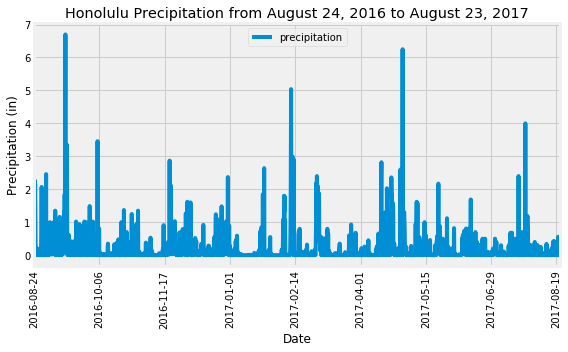

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
df_prcp.plot(figsize = (8, 5), title = 'Honolulu Precipitation from August 24, 2016 to August 23, 2017')

plt.xlabel('Date')
plt.ylabel('Precipitation (in)')

plt.xticks(rotation = 90)
plt.legend(loc = 'upper center')

plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Checking column names
inspector = inspect(engine)
col = inspector.get_columns('station')
for c in col:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).group_by(Station.id).count()

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Station.station, func.count(Measurement.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
info = session.query(func.min(Measurement.tobs),\
                     func.max(Measurement.tobs),\
                     func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
info

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Summary so far
print(f'The station with the highest number of observations is {active[0][0]}.')
print(f'The lowest temperature observed at {active[0][0]} is {info[0][0]}F.')
print(f'The highest temperature observed at {active[0][0]} is {info[0][1]}F.')
print(f'The average temperature observed at {active[0][0]} is {round(info[0][2], 1)}F.')

The station with the highest number of observations is USC00519281.
The lowest temperature observed at USC00519281 is 54.0F.
The highest temperature observed at USC00519281 is 85.0F.
The average temperature observed at USC00519281 is 71.7F.


In [23]:
# Choose the station with the highest number of temperature observations.
# Latest observed date for the station with the highest number of temperature observations
session.query(Measurement.date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()

('2017-08-18')

In [24]:
# Calculate the date 1 year ago from the last data point in the database
last12_2 = dt.date(2017, 8, 18) - dt.timedelta(days = 365)
print(last12_2)

2016-08-18


In [25]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observed = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > last12_2).\
    order_by(Measurement.date).all()

In [26]:
# Putting into a dataframe
df_temp = pd.DataFrame(observed).set_index('date')
df_temp.head()

,tobs
date,
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0
2016-08-23,77.0


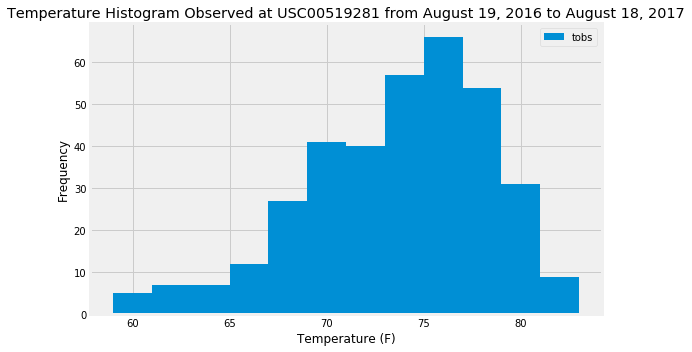

In [27]:
# Creating a histogram
df_temp.plot(kind = 'hist', bins = 12, figsize = (9, 5))

plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Histogram Observed at ' + active[0][0] + ' from August 19, 2016 to August 18, 2017')

plt.tight_layout()
plt.show()

## Optional Challenge Assignment

### Temperature Analysis I
An unpaired t-test is applicable as temperature data being compared stem from two different sets (e.g. months).

In [28]:
# Calculating average temperatures of June and December
june_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime('%m', Measurement.date) == '06').all()
dec_avg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime('%m', Measurement.date) == '12').all()

print(f'''The average temperature of June is {round(june_avg[0][0], 1)}F.
The average temperature of December is {round(dec_avg[0][0], 1)}F.''')

The average temperature of June is 74.9F.
The average temperature of December is 71.0F.


In [29]:
# Storing June and December data
june = session.query(Measurement.tobs).\
    filter(func.strftime('%m', Measurement.date) == '06').all()
dec = session.query(Measurement.tobs).\
    filter(func.strftime('%m', Measurement.date) == '12').all()

june_df = pd.DataFrame(june)
dec_df = pd.DataFrame(dec)

In [30]:
# Performing t-test
import scipy.stats as stat

(ttest, p) = stat.ttest_ind(june_df['tobs'], dec_df['tobs'])

if p < 0.05:
    print(f'There is a meaningful difference between temperatures in June and December. The p-value is {p}.')
else:
    print(f'There is not a meaningful difference between temperatures in June and December. The p-value is {p}.')

There is a meaningful difference between temperatures in June and December. The p-value is 3.9025129038616655e-191.


### Temperature Analysis II

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-05-21', '2017-05-28')

print(trip_temp)

tmin = trip_temp[0][0]
tavg = trip_temp[0][1]
tmax = trip_temp[0][2]

[(69.0, 75.08695652173913, 87.0)]


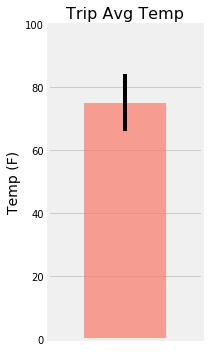

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize = (3, 5))

plt.bar('dummy', tavg, yerr = (tmax - tmin)/2, color = 'salmon', alpha = 0.75)
plt.xlim(-0.75, 0.75)
plt.ylim(0, 100)

plt.xticks('')

plt.title('Trip Avg Temp', fontsize = 16)
plt.ylabel('Temp (F)', fontsize = 14)

plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = dt.datetime.strptime('2017-05-21', '%Y-%m-%d')
end_date = dt.datetime.strptime('2017-05-28', '%Y-%m-%d')

total_rain = session.query(Station.station,\
                           Station.name,\
                           Station.latitude,\
                           Station.longitude,\
                           Station.elevation,\
                           func.sum(Measurement.prcp)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date.between(start_date, end_date)).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for s in total_rain:
    print(s)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.29)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.28)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.1600000000000001)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.7)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.39)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.30000000000000004)


In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

# Use the start and end date to create a range of dates
date_duration = (end_date - start_date).days
date_range = [start_date + dt.timedelta(days = x) for x in range(date_duration + 1)]

# Stip off the year and save a list of %m-%d strings
clean_range = [dt.datetime.strftime(x, '%m-%d') for x in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(x)[0] for x in clean_range]
normals


[(64.0, 72.96428571428571, 80.0),
 (64.0, 74.45614035087719, 80.0),
 (68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0)]

In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_dict = []

for row in normals:
    pre_df = {}
    pre_df['Date'] = start_date
    pre_df['TMIN'] = row[0]
    pre_df['TAVG'] = round(row[1], 1)
    pre_df['TMAX'] = row[2]
    normals_dict.append(pre_df)
    start_date += dt.timedelta(days = 1)

normals_df = pd.DataFrame(normals_dict).set_index('Date')
normals_df

,TAVG,TMAX,TMIN
Date,,,
2017-05-21,73.0,80.0,64.0
2017-05-22,74.5,80.0,64.0
2017-05-23,74.9,87.0,68.0
2017-05-24,73.9,79.0,67.0
2017-05-25,74.3,79.0,68.0
2017-05-26,74.0,82.0,65.0
2017-05-27,74.5,80.0,65.0
2017-05-28,74.3,82.0,67.0


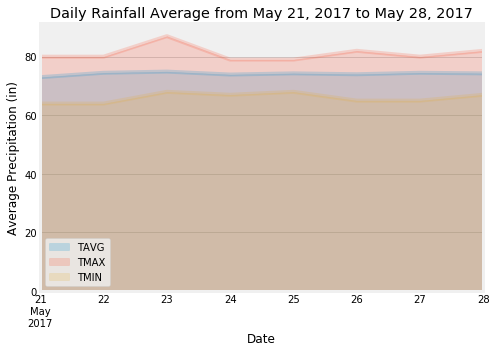

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, figsize = (7, 5), alpha = 0.2)

plt.title('Daily Rainfall Average from May 21, 2017 to May 28, 2017')

plt.xlabel('Date')
plt.ylabel('Average Precipitation (in)')

plt.tight_layout()
plt.show()